In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import Constant
from tensorflow.keras.initializers import RandomNormal, HeNormal, GlorotNormal
import cv2

from sklearn.model_selection import train_test_split

In [2]:
def get_DO_label(val):
    if val <= 7.0:
    	return "DO_S"
    elif val <= 8.0:
    	return "DO_M"
    elif val <= 9.0:
    	return "DO_L"

In [3]:
APRIL_DO = 9.0
MAY_DO = 8.4
JUNE_DO = 8.5
JULY_DO = 6.4
AUGUST_DO = 8.1
SEPTEMBER_DO = 7.7
OCTOBER_DO = 7.8

In [4]:
print("April DO:", APRIL_DO)
print("May DO:", MAY_DO)
print("June DO:", JUNE_DO)
print("July DO:", JULY_DO)
print("August DO:", AUGUST_DO)
print("September DO:", SEPTEMBER_DO)
print("October DO:", OCTOBER_DO)

April DO: 9.0
May DO: 8.4
June DO: 8.5
July DO: 6.4
August DO: 8.1
September DO: 7.7
October DO: 7.8


In [5]:
folder_paths = ['./水質檢測/Image_data/1_April',
                './水質檢測/Image_data/2_May',
                './水質檢測/Image_data/3_June',
                './水質檢測/Image_data/4_July',
                './水質檢測/Image_data/5_August',
                './水質檢測/Image_data/6_September']
labels = [get_DO_label(APRIL_DO), get_DO_label(MAY_DO), get_DO_label(JUNE_DO), 
          get_DO_label(JULY_DO), get_DO_label(AUGUST_DO), get_DO_label(SEPTEMBER_DO)]  # 对应文件夹1和文件夹2的标签


oct_paths = ["./水質檢測/Image_data/7_October"]
oct_label_Stirng = [get_DO_label(OCTOBER_DO)]

In [6]:
import tensorflow as tf
import os

def load_and_label_images(folder_path, label):
    image_paths = []  # 存储图像文件的路径
    labels = []       # 存储图像对应的标签

    # 获取文件夹中的所有图像文件的路径
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 假设只加载jpg和png格式的图像文件
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)

    # 加载图像并为其指定标签
    images = [tf.io.read_file(image_path) for image_path in image_paths]
    images = [tf.image.decode_image(image, channels=3) for image in images]

    # 可选的数据预处理：这里假设对图像进行归一化
    #images = [tf.cast(image, tf.float32) / 255.0 for image in images]

    return images, labels

In [7]:
# 你可以根据需要加载多个文件夹中的图像并为其指定不同的标签
# folder_paths = ['/path/to/folder1', '/path/to/folder2']
# labels = [1, 2]  # 对应文件夹1和文件夹2的标签

# 加载所有文件夹中的图像和标签
all_images = []
all_labels = []
for folder_path, label in zip(folder_paths, labels):
    images, labels = load_and_label_images(folder_path, label)
    all_images.extend(images)
    all_labels.extend(labels)
    

oct_images = []
oct_labels = []
for oct_path, label in zip(oct_paths, oct_label_Stirng):
    images, labels = load_and_label_images(oct_path, oct_label_Stirng)
    images_resized = [tf.image.resize(img, (224, 224)) for img  in images]
    oct_images.extend(images_resized)
    oct_labels.extend(labels)

In [8]:
# print(all_labels)
# print(oct_labels)

label_mapping = {
    "DO_S":tf.constant([1,0,0], dtype=tf.float32),
    "DO_M":tf.constant([0,1,0], dtype=tf.float32),
    "DO_L":tf.constant([0,0,1], dtype=tf.float32)
}

# unique_labels_list = list(set(all_labels))
# unique_labels_list.sort()
# label_to_index = {label: index for index, label in enumerate(unique_labels_list)}
# label_one_hot = [tf.one_hot(label_to_index[label], len(unique_labels_list)) for label in all_labels]
label_one_hot = [label_mapping[label] for label in all_labels]
oct_label_one_hot = [label_mapping[label[0]] for label in oct_labels]

In [9]:
print(len(all_images))
print(all_images[0].shape)
print(len(label_one_hot))
print(label_one_hot[0:10])

print("=============================")

print(len(oct_images))
print(oct_images[0].shape)
print(len(oct_label_one_hot))
print(oct_label_one_hot[0:10])

9728
(224, 224, 3)
9728
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>]
625
(224, 224, 3)
625
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array

In [10]:

train_images, validation_images, train_labels, validation_labels = train_test_split(all_images, label_one_hot, test_size=0.2, random_state=42)

# 创建训练集数据集
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(batch_size=32)

# 创建验证集数据集
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
validation_dataset = validation_dataset.shuffle(buffer_size=len(validation_images)).batch(batch_size=32)

# 創建測試資料集
test_dataset = tf.data.Dataset.from_tensor_slices((oct_images, oct_label_one_hot))
test_dataset = test_dataset.shuffle(buffer_size=len(oct_images)).batch(batch_size=32)


In [19]:
import tensorflow as tf

# 定义一个简单的卷积神经网络模型
def create_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1), 
    tf.keras.layers.Conv2D(4, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),   
    tf.keras.layers.Dense(3, activation='softmax')
])
    return model

In [20]:
model = create_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

/Users/future-outlier/miniconda3/envs/dev/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_DO_model.keras',  # 保存模型的文件路径
    monitor='val_accuracy',    # 监控的指标，可以是'val_loss'或'val_accuracy'
    save_best_only=True,       # 仅保存最好的模型
    mode='max',                # 对于准确率，使用'max'模式
    verbose=1                  # 输出详细日志信息
)

In [22]:
result = model.fit(train_dataset, 
                   validation_data=validation_dataset, 
                   epochs=2,verbose=1, 
                   callbacks=[checkpoint_callback])

Epoch 1/2
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6859 - loss: 4.0533
Epoch 1: val_accuracy improved from -inf to 0.98304, saving model to best_DO_model.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.6869 - loss: 4.0297 - val_accuracy: 0.9830 - val_loss: 0.0868
Epoch 2/2
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9656 - loss: 0.1090
Epoch 2: val_accuracy improved from 0.98304 to 0.98921, saving model to best_DO_model.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9656 - loss: 0.1087 - val_accuracy: 0.9892 - val_loss: 0.0251


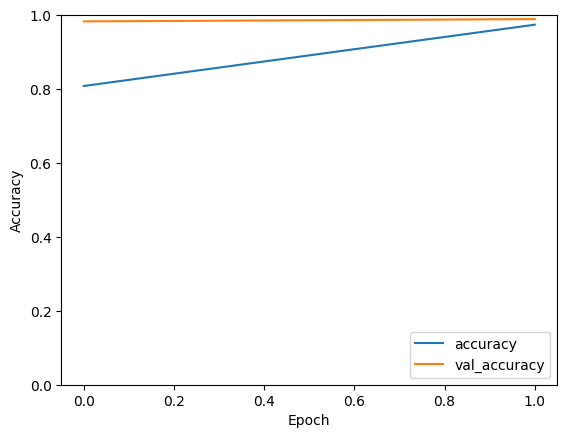

In [23]:
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [24]:
# from time import datetime
# model_name = "model" + datetime.now().strftime("%Y-%m-%d") + ".h5"
model_name = "DO_model.h5"
model.save(model_name)

In [25]:
model = tf.keras.models.load_model(model_name)

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 使用model預測
predictions = model.predict(test_dataset)
# 轉換成class index
predicted_classes_index = np.argmax(predictions, axis=1)
true_classes_index = np.argmax([label.numpy() for label in oct_label_one_hot], axis=1)

# 計算confusion matrix
conf_matrix = confusion_matrix(true_classes_index, predicted_classes_index)

print("Confusion Matrix:")
print(conf_matrix)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix:
[[  0   0   0]
 [ 77   2 546]
 [  0   0   0]]
